# **<span style="color:#121CB6;">Credit Risk Analysis using KNN</span>**

- We start with importing all libraries that are needed.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex
sns.set_style('whitegrid')
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from joblib import Parallel, delayed
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# **<span style="color:#121CB6;">1.Loading and Understanding the dataset</span>**

In [ ]:
df_loan = pd.read_csv("/content/drive/MyDrive/loan/loan.csv", encoding='utf-8')
df_loan.head(7)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1075269,1311441,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1069639,1304742,7000.0,7000.0,7000.0,60 months,15.96,170.08,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53768 entries, 0 to 53767
Data columns (total 74 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           53768 non-null  int64  
 1   member_id                    53768 non-null  int64  
 2   loan_amnt                    53768 non-null  float64
 3   funded_amnt                  53768 non-null  float64
 4   funded_amnt_inv              53768 non-null  float64
 5   term                         53768 non-null  object 
 6   int_rate                     53768 non-null  float64
 7   installment                  53768 non-null  float64
 8   grade                        53768 non-null  object 
 9   sub_grade                    53768 non-null  object 
 10  emp_title                    50394 non-null  object 
 11  emp_length                   52147 non-null  object 
 12  home_ownership               53767 non-null  object 
 13  annual_inc      

# **<span style="color:#121CB6;">2. Removing Irrelevant coloumn</span>**

In [ ]:
df_loan.drop(columns=df_loan.columns.difference(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership',
                                                 'annual_inc', 'verification_status', 'loan_status', 'purpose']), inplace=True)

In [ ]:
df_loan.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
emp_length             1621
home_ownership            1
annual_inc                5
verification_status       1
loan_status               1
purpose                   1
dtype: int64

There are many "Missing Values" in Column "emp_length" and few in "annual_inc".

In [ ]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53768 entries, 0 to 53767
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            53768 non-null  float64
 1   term                 53768 non-null  object 
 2   int_rate             53768 non-null  float64
 3   installment          53768 non-null  float64
 4   grade                53768 non-null  object 
 5   emp_length           52147 non-null  object 
 6   home_ownership       53767 non-null  object 
 7   annual_inc           53763 non-null  float64
 8   verification_status  53767 non-null  object 
 9   loan_status          53767 non-null  object 
 10  purpose              53767 non-null  object 
dtypes: float64(4), object(7)
memory usage: 4.5+ MB


In [ ]:
df_loan.head(10)

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose
0,5000.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card
1,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,car
2,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business
3,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,other
4,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,Current,other
5,5000.0,36 months,7.90,156.46,A,3 years,RENT,36000.0,Source Verified,Fully Paid,wedding
6,7000.0,60 months,15.96,170.08,C,8 years,RENT,47004.0,Not Verified,Current,debt_consolidation
7,3000.0,36 months,18.64,109.43,E,9 years,RENT,48000.0,Source Verified,Fully Paid,car
8,5600.0,60 months,21.28,152.39,F,4 years,OWN,40000.0,Source Verified,Charged Off,small_business
9,5375.0,60 months,12.69,121.45,B,< 1 year,RENT,15000.0,Verified,Charged Off,other


In [ ]:
df_loan.annual_inc = df_loan.annual_inc.fillna(0)
df_loan.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
emp_length             1621
home_ownership            1
annual_inc                0
verification_status       1
loan_status               1
purpose                   1
dtype: int64

- to eliminate null values, the annual income column is filled with the value 0

# **<span style="color:#121CB6;">3. Create label Coloumn : Description about loan status</span>**

- In this column, the value 0 will be filled with the correct conditions: 'Fully Paid', 'Does not meet the credit policy. Status:Fully Paid', 'Current'
- Meanwhile, the value of 1 will be filled with incorrect conditions: 'Late (31-120 days)', 'Late (16-30 days)', 'In Grace Period', 'Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off'

In [ ]:
# binary classification
label_categories = [
    (0, ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid', 'Current']),
    (1, ['Late (31-120 days)', 'Late (16-30 days)', 'In Grace Period',
         'Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off'])
]

# function to apply the transformation
def classify_label(text):
    if pd.isna(text):
        return None
    for category, matches in label_categories:
        if any(match in text for match in matches):
            return category
    return None

df_loan.loc[:, 'label'] = df_loan['loan_status'].apply(classify_label)
df_loan = df_loan.drop('loan_status', axis=1)

In [ ]:
# label several label with specific grading system.
def SC_LabelEncoder1(text):
    if text == "E":
        return 1
    elif text == "D":
        return 2
    elif text == "C":
        return 3
    elif text == "B":
        return 4
    elif text == "A":
        return 5
    else:
        return 0


def SC_LabelEncoder2(text):
    if text == "< 1 year":
        return 1
    elif text == "1 year":
        return 2
    elif text == "2 years":
        return 3
    elif text == "3 years":
        return 4
    elif text == "4 years":
        return 5
    elif text == "5 years":
        return 6
    elif text == "6 years":
        return 7
    elif text == "7 years":
        return 8
    elif text == "8 years":
        return 9
    elif text == "9 years":
        return 10
    elif text == "10 years":
        return 11
    elif text == "10+ years":
        return 12
    else:
        return 0

def SC_LabelEncoder3(text):
    if text == "RENT":
        return 1
    elif text == "MORTGAGE":
        return 2
    elif text == "OWN":
        return 3
    else:
        return 0

df_loan["grade"] = df_loan["grade"].apply(SC_LabelEncoder1)
df_loan["emp_length"] = df_loan["emp_length"].apply(SC_LabelEncoder2)
df_loan["home_ownership"] = df_loan["home_ownership"].apply(SC_LabelEncoder3)

In [ ]:
df_loan.head(10)

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,label
0,5000.0,36 months,10.65,162.87,4,12,1,24000.0,Verified,credit_card,0.0
1,2500.0,60 months,15.27,59.83,3,1,1,30000.0,Source Verified,car,1.0
2,2400.0,36 months,15.96,84.33,3,12,1,12252.0,Not Verified,small_business,0.0
3,10000.0,36 months,13.49,339.31,3,12,1,49200.0,Source Verified,other,0.0
4,3000.0,60 months,12.69,67.79,4,2,1,80000.0,Source Verified,other,0.0
5,5000.0,36 months,7.90,156.46,5,4,1,36000.0,Source Verified,wedding,0.0
6,7000.0,60 months,15.96,170.08,3,9,1,47004.0,Not Verified,debt_consolidation,0.0
7,3000.0,36 months,18.64,109.43,1,10,1,48000.0,Source Verified,car,0.0
8,5600.0,60 months,21.28,152.39,0,5,3,40000.0,Source Verified,small_business,1.0
9,5375.0,60 months,12.69,121.45,4,1,1,15000.0,Verified,other,1.0


In [ ]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53768 entries, 0 to 53767
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            53768 non-null  float64
 1   term                 53768 non-null  object 
 2   int_rate             53768 non-null  float64
 3   installment          53768 non-null  float64
 4   grade                53768 non-null  int64  
 5   emp_length           53768 non-null  int64  
 6   home_ownership       53768 non-null  int64  
 7   annual_inc           53768 non-null  float64
 8   verification_status  53767 non-null  object 
 9   purpose              53767 non-null  object 
 10  label                53767 non-null  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 4.5+ MB


# **<span style="color:#121CB6;">4. Exploratory Data Analysis</span>**

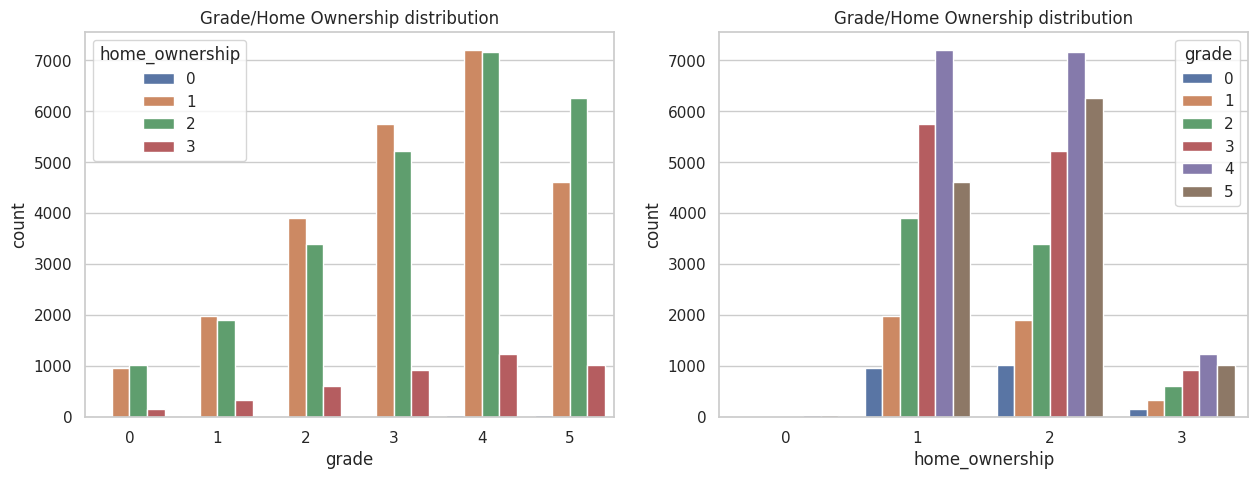

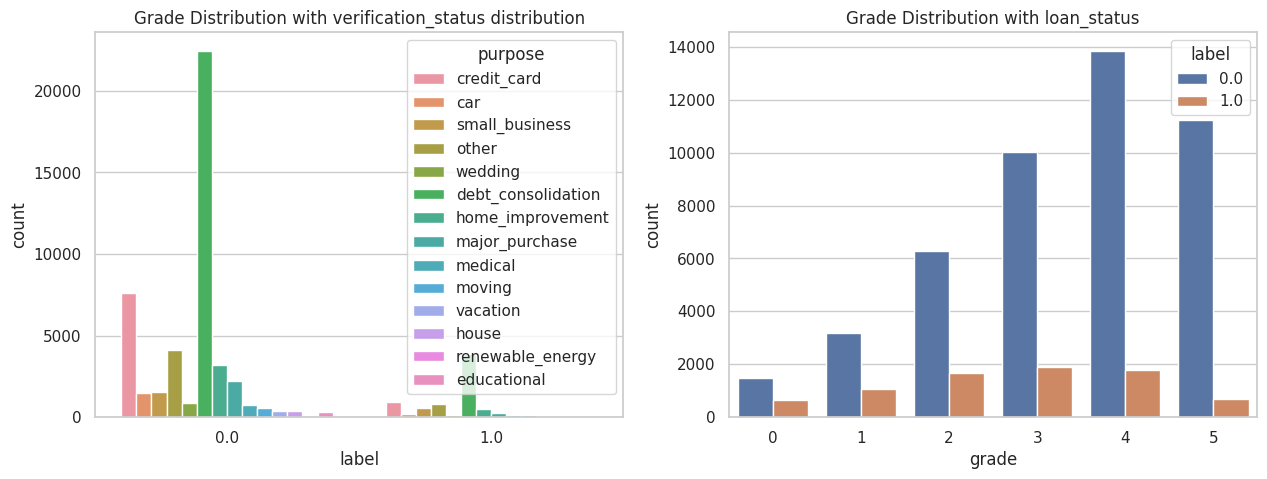

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=df_loan, x='grade', hue="home_ownership", ax=ax[0]).set_title("Grade/Home Ownership distribution");
sns.countplot(data=df_loan, x='home_ownership', hue='grade', ax=ax[1]).set_title("Grade/Home Ownership distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=df_loan, x='label', hue='purpose', ax=ax[0]).set_title("Grade Distribution with verification_status distribution");
sns.countplot(data=df_loan, x='grade', hue='label', ax=ax[1]).set_title("Grade Distribution with loan_status");

## Analysis :
1. The number of Borrowers with high grade will be small compared to low grade
2. Most money borrowers' goals from labels 0 and 1 are debt consolidation
3. The highest number of grades who were able to complete the loan was grade 4, while the most failed to complete the loan was grade 3

Text(0.5, 1.0, 'Loan amounts grouped by purpose')

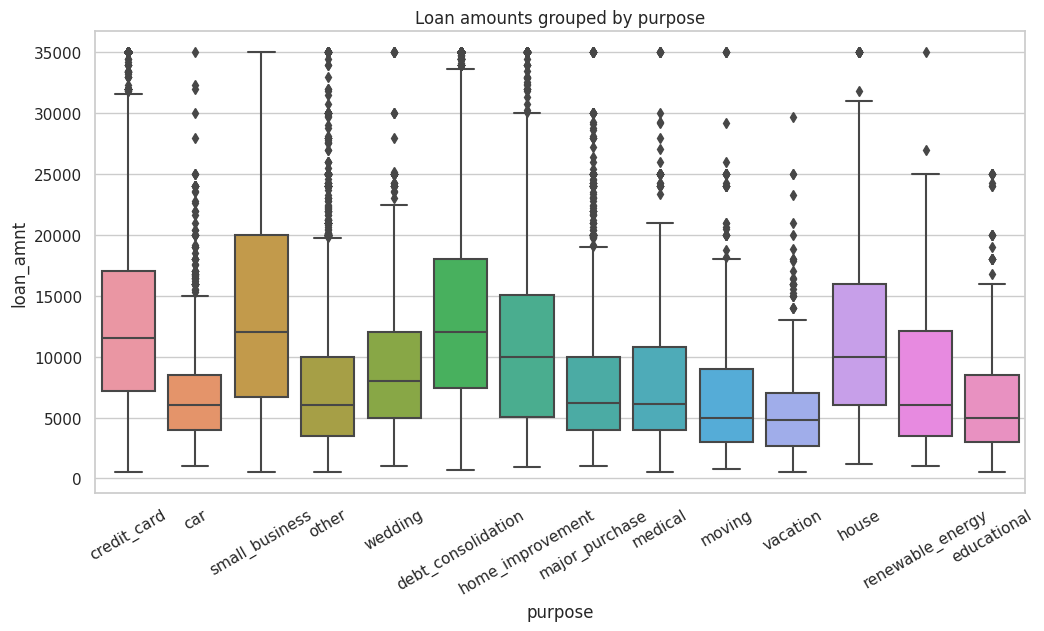

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='purpose', y='loan_amnt', data=df_loan)
plt.xticks(rotation=30)
plt.title('Loan amounts grouped by purpose')

## Analysis :
There are 5 highest categories for the amount of credit with the following purposes: Credit card, MSME business, debt consolidation, home improvement, and buying a house

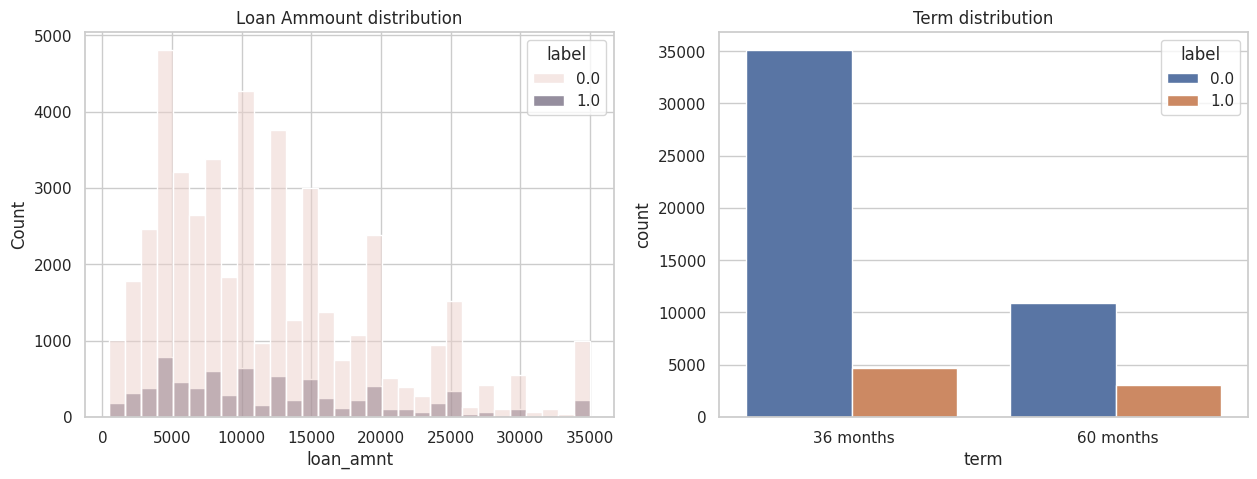

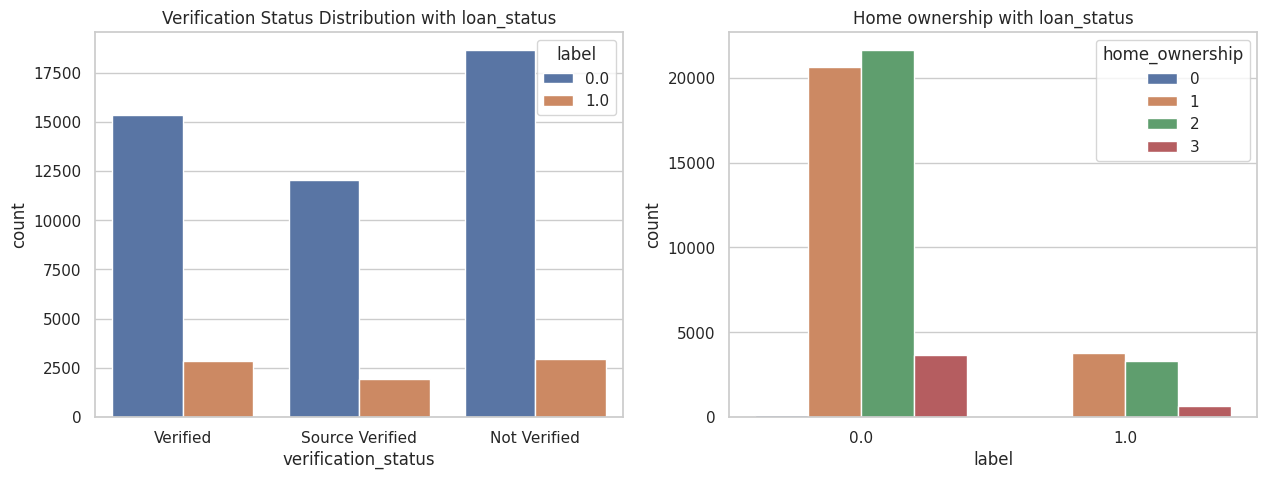

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df_loan, x='loan_amnt',hue="label", bins=30, ax=ax[0]).set_title("Loan Ammount distribution");
sns.countplot(data=df_loan, x='term', hue="label", ax=ax[1]).set_title("Term distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=df_loan, hue='home_ownership', x='label', ax=ax[1]).set_title("Home ownership with loan_status");
sns.countplot(data=df_loan, x='verification_status', hue='label', ax=ax[0]).set_title("Verification Status Distribution with loan_status");

## Analysis :
1. The nominal value of the largest debt is 10000 USD
2. The maximum maturity is 36 months, while for 60 months it is almost a third
3. Most of the credits that can be paid in full are obtained from the "Verified" verification status

- Seeing the correlation between variables:

<ipython-input-85-663651c4ec55>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_loan[['loan_amnt', 'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc','purpose','label']].corr()


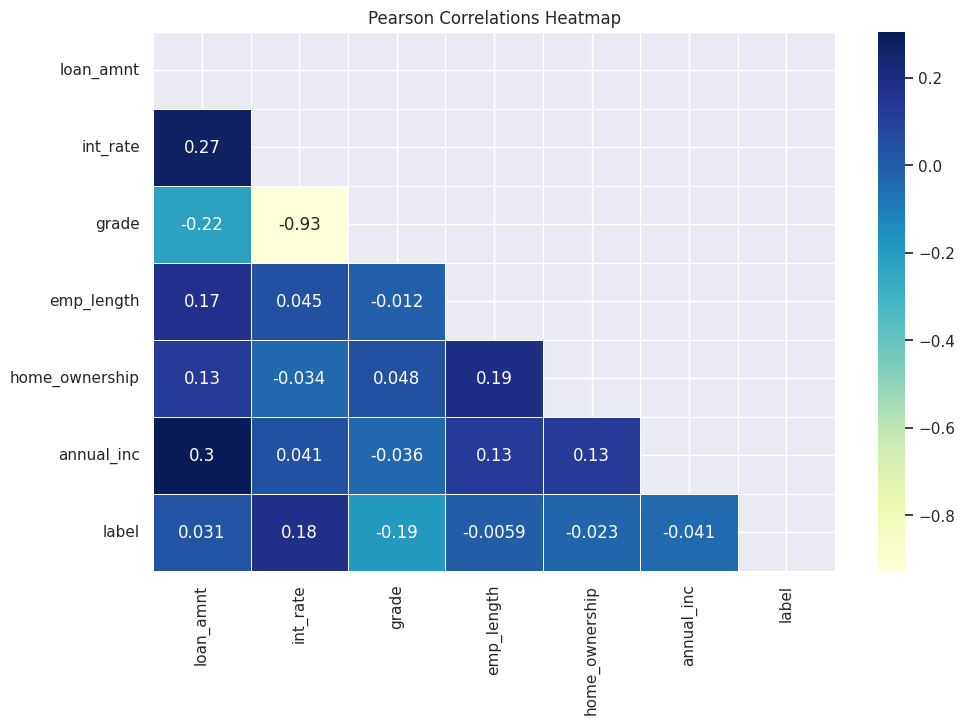

In [ ]:
corr = df_loan[['loan_amnt', 'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc','purpose','label']].corr()
sns.set(rc={'figure.figsize':(11,7)})
sns.heatmap(corr, linewidths=.5, annot=True, cmap="YlGnBu", mask=np.triu(np.ones_like(corr, dtype=bool)))\
    .set_title("Pearson Correlations Heatmap");

## Analysis :
The amount of credit is very dependent on the annual income of the borrower

# **<span style="color:#121CB6;">5. Pra-Processing data for Discrete Coloumn</span>**

In [ ]:
# use LabelEncoder() to encode another category column:
for col in ["verification_status", "purpose","term"]:
    le = LabelEncoder()
    le.fit(df_loan[col])
    df_loan[col] = le.transform(df_loan[col])
df_loan.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,label
0,5000.0,0,10.65,162.87,4,12,1,24000.0,2,1,0.0
1,2500.0,1,15.27,59.83,3,1,1,30000.0,1,0,1.0
2,2400.0,0,15.96,84.33,3,12,1,12252.0,0,11,0.0
3,10000.0,0,13.49,339.31,3,12,1,49200.0,1,9,0.0
4,3000.0,1,12.69,67.79,4,2,1,80000.0,1,9,0.0


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['loan_amnt'].plot(kind='hist', bins=20, title='loan_amnt')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['term'].plot(kind='hist', bins=20, title='term')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['int_rate'].plot(kind='hist', bins=20, title='int_rate')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='loan_amnt', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='loan_amnt', y='term', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='term', y='int_rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='int_rate', y='installment', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['loan_amnt']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('loan_amnt')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['term']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('term')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['int_rate']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('int_rate')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['installment']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('installment')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['loan_amnt'].plot(kind='line', figsize=(8, 4), title='loan_amnt')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['term'].plot(kind='line', figsize=(8, 4), title='term')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['int_rate'].plot(kind='line', figsize=(8, 4), title='int_rate')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
df_loan.isnull().sum()

loan_amnt              0
term                   0
int_rate               0
installment            0
grade                  0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
purpose                0
label                  1
dtype: int64

In [ ]:
df_loan.label = df_loan.label.fillna(1)

# **<span style="color:#121CB6;">6. Clustering</span>**

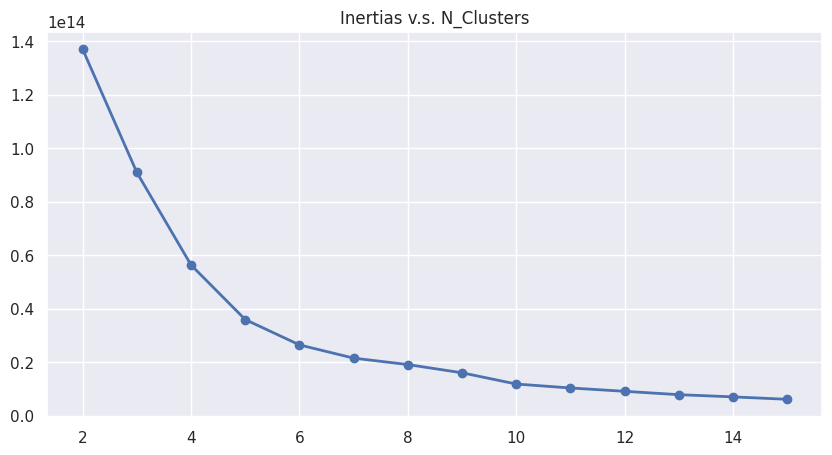

In [ ]:
inertias = []

for i in range(2, 16):
    kmeans = KMeans(n_clusters=i, n_init='auto', random_state=0).fit(df_loan)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.title('Inertias v.s. N_Clusters')
plt.plot(np.arange(2, 16), inertias, marker='o', lw=2);

## Analysis:
"Elbow" on the chart above is at 4. The number of clusters must be 4.

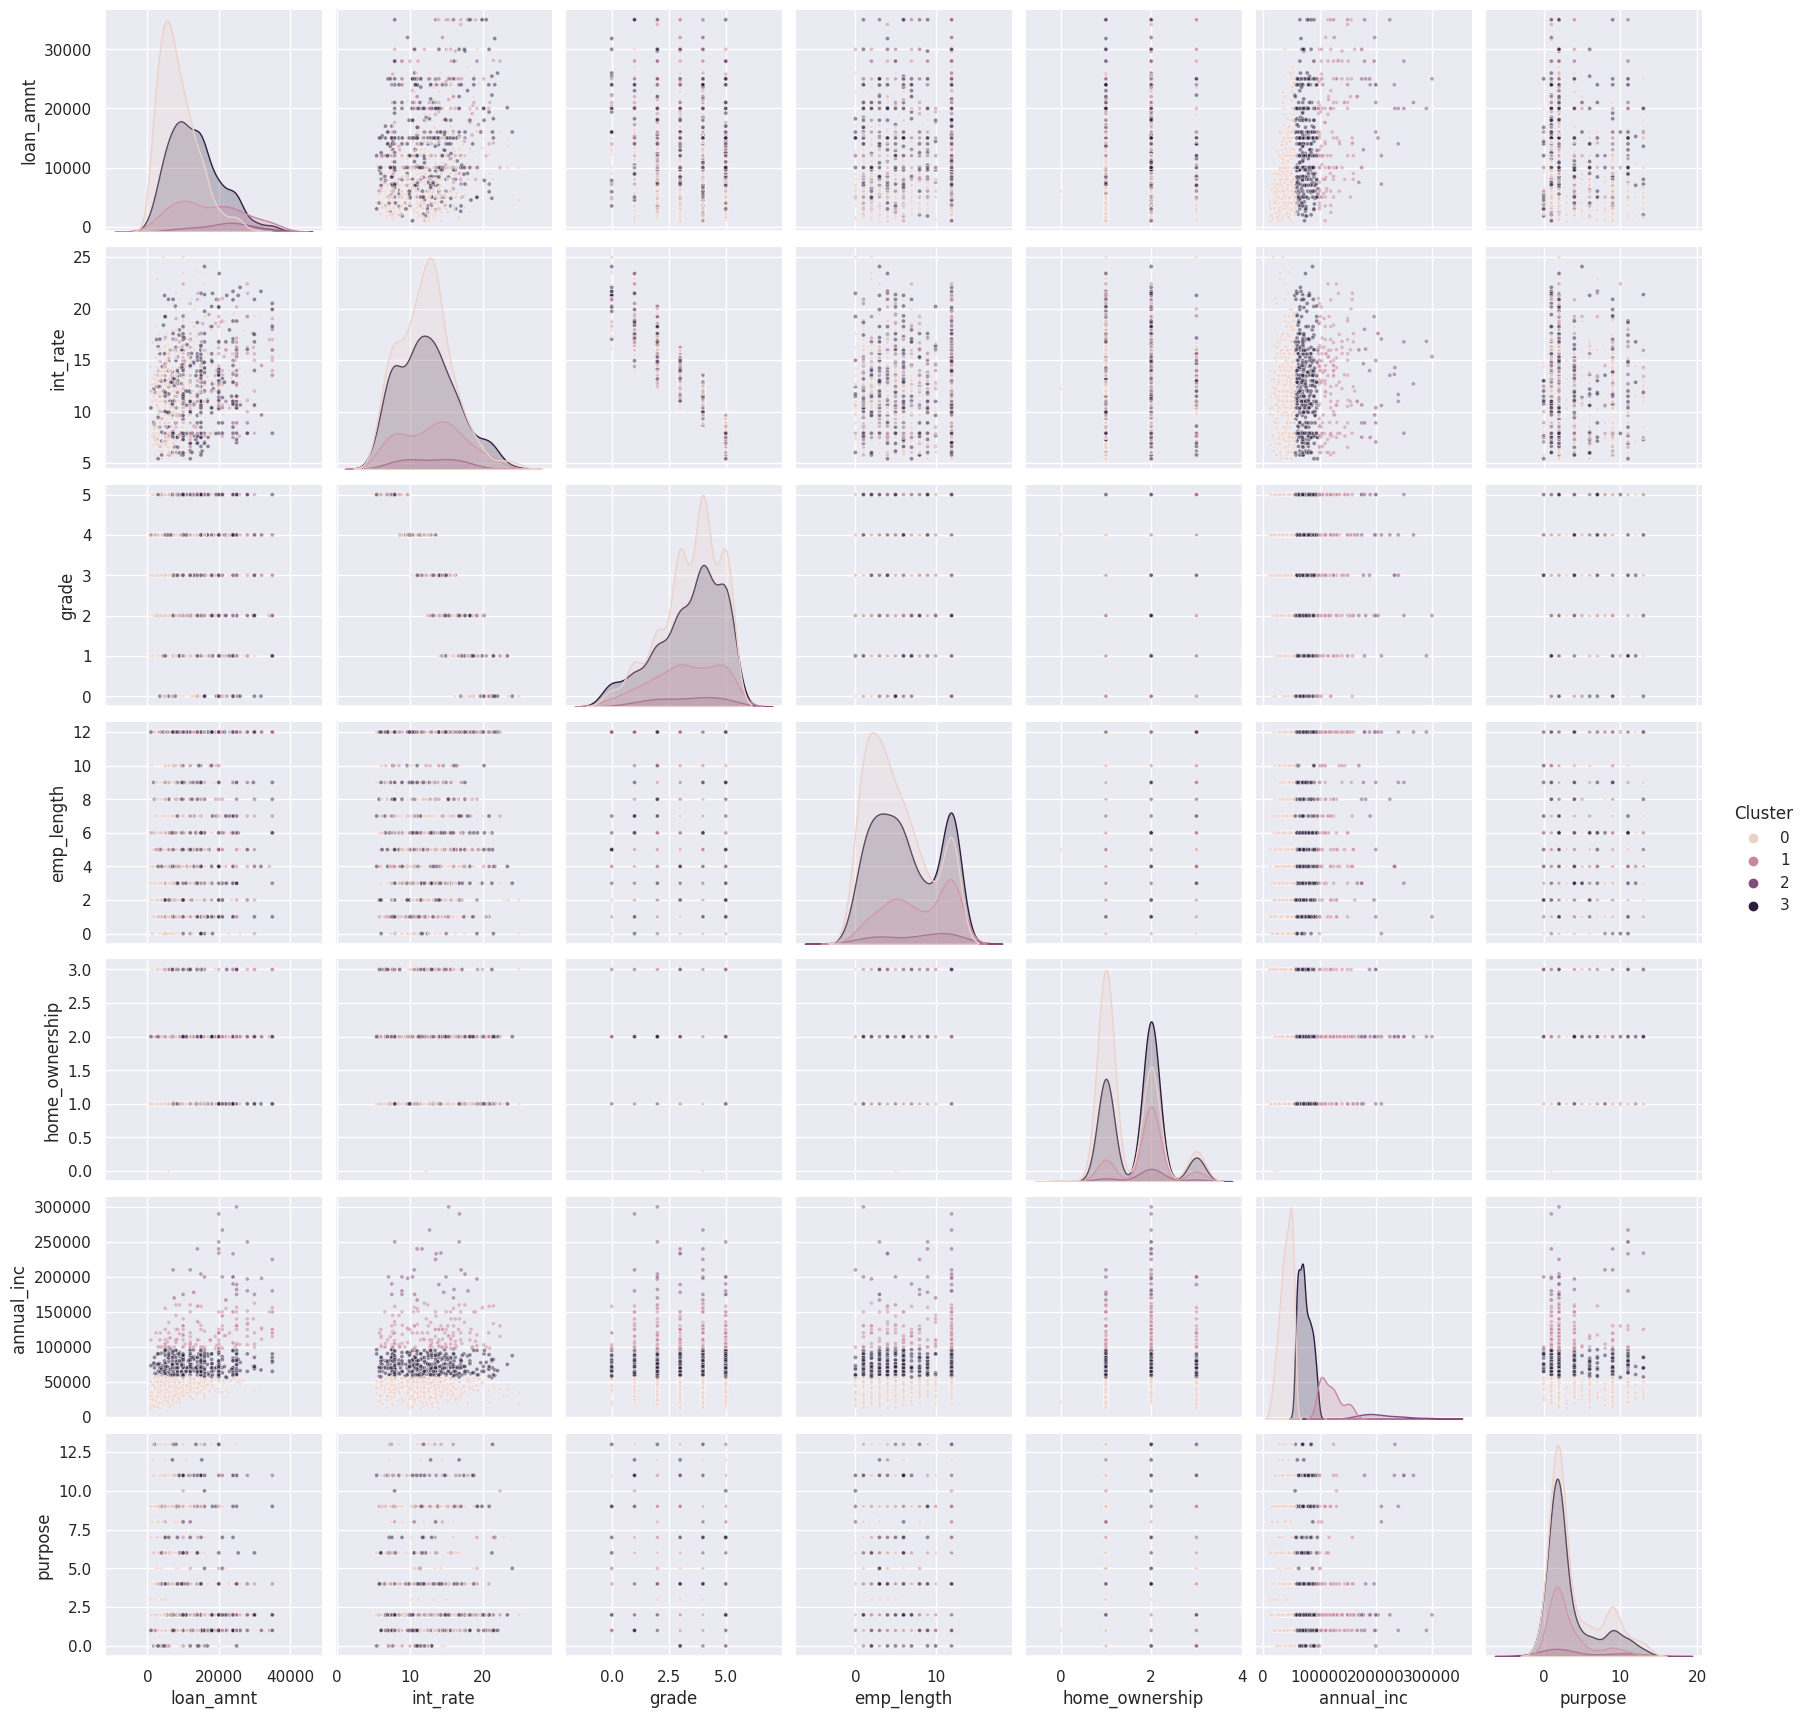

In [ ]:
sample_size = 1000  # Adjust the sample size based on your data size
df_sample = df_loan.sample(sample_size, random_state=0)

km = KMeans(n_clusters=4, n_init=10, random_state=0)
clusters = km.fit_predict(df_sample)

# Creating a DataFrame for clustered data
df_clustered = df_sample[['loan_amnt', 'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'purpose']].copy()
df_clustered.loc[:, "Cluster"] = clusters

# Visualizing the clustered data using pairplot
sns.pairplot(df_clustered[['loan_amnt', 'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'purpose', 'Cluster']],
             hue="Cluster", markers='.', plot_kws={'alpha':0.5});

# **<span style="color:#121CB6;">7. Predicting Risk: Using the K-Nearest Neighbors Classification Model</span>**

In [ ]:
X, y = df_loan.drop("label", axis=1), df_loan["label"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=0)

In [ ]:
max_score = 0
max_k = 0

def calculate_score(k, X_train, y_train, X_test, y_test):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    score = f1_score(y_test, neigh.predict(X_test), average='micro')
    return k, score

results = Parallel(n_jobs=-1)(delayed(calculate_score)(k, X_train, y_train, X_test, y_test) for k in range(1, 100))

for k, score in results:
    if score > max_score:
        max_k = k
        max_score = score

In [ ]:
print('Jika kita menggunakan K-Nearest Neighbors Classification, maka nilai K yang terbaik adalah', str(max_k), 'untuk mendapatkan prediksi terbaik, dengan akurasi rata-rata sebesar', max_score)

Jika kita menggunakan K-Nearest Neighbors Classification, maka nilai K yang terbaik adalah 20 untuk mendapatkan prediksi terbaik, dengan akurasi rata-rata sebesar 0.8527989585270597


Classification with other ML models

Since the KNN (K-Nearest Neighbors) Classification takes a lot of time and memory to predict, it is possible to use other ML models such as SVC, DecisionTree, RandomForest, and GaussianNaiveBayes.

However, in this notebook, We use KNN Model Only, and it is done and has got a good accuracy = 85,27%

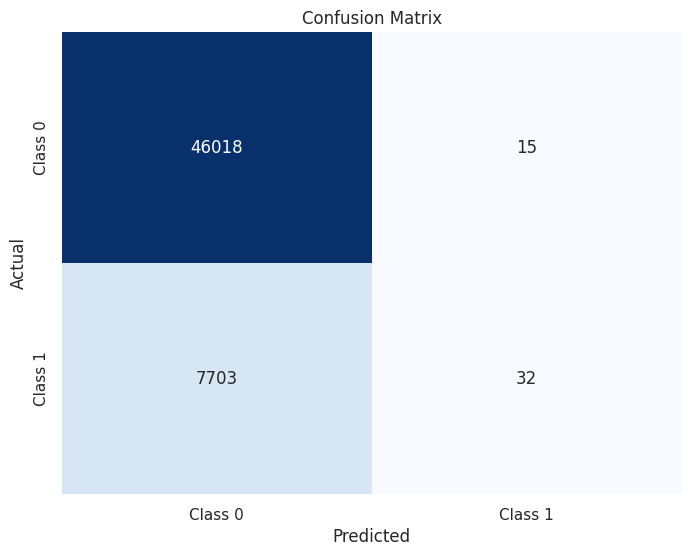

In [ ]:
# Memasukkan nilai sebenarnya
y_true = df_loan['label']

# Menggunakan model K-Nearest Neighbors yang telah dibuat sebelumnya
y_pred = best_neigh.predict(X)  # Sesuaikan dengan data yang sesuai, dalam hal ini X adalah semua fitur dalam df_loan

# Membuat Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi Confusion Matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Model K-Nearest Neighbors
best_neigh = KNeighborsClassifier(n_neighbors=max_k)
best_neigh.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = best_neigh.predict(X_test)

# Membuat Classification Report
report = classification_report(y_test, y_pred)

print("Classification Report :")
print(report)

Classification Report :
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92      9169
         1.0       0.67      0.00      0.01      1585

    accuracy                           0.85     10754
   macro avg       0.76      0.50      0.46     10754
weighted avg       0.83      0.85      0.79     10754

